Evaluating best models after hyper-parameter tuning with 5-fold cross validation. Final soft label is based on the average of predicted soft labels from the five cross validation models. The best models are selected and saved by running the `rnn_main.py` file under the `Python` fold. The log files of the cross validation can be found in `output/rnn_hp.txt`.

===> Loading datasets
Train/Test data size: 4885/543
===> Evaluate test data


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


===> Best model:
RNN(
  (fc0): Linear(in_features=45, out_features=32, bias=True)
  (tanh): Tanh()
  (gru): GRU(32, 64, num_layers=3, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
AUC on test data: 0.8410383597883598


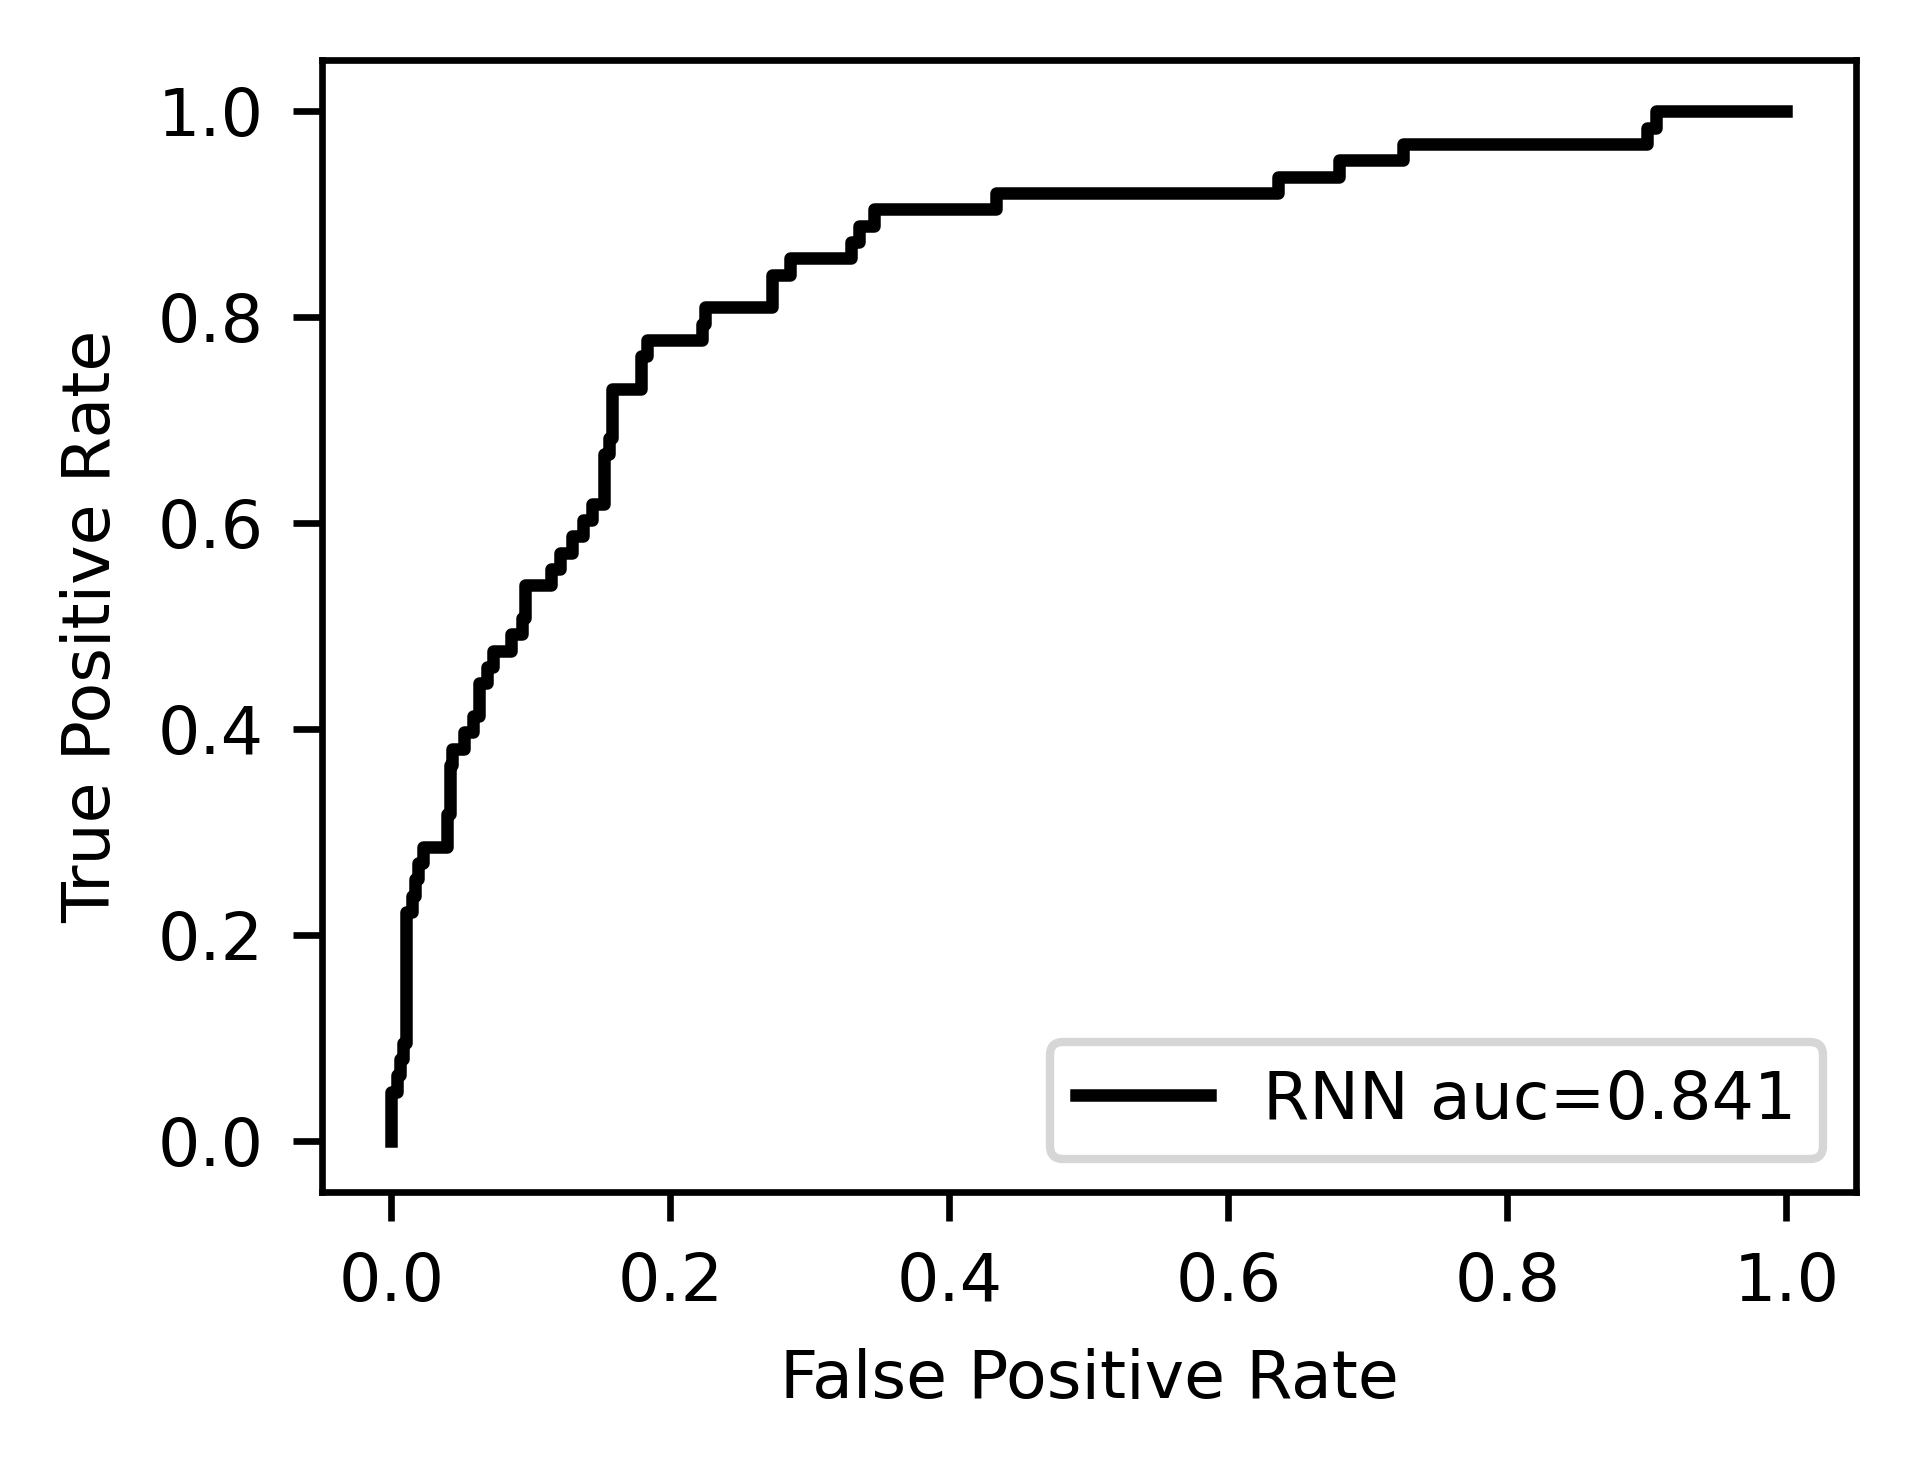

In [1]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from Python.model_data import model_data
from Python.rnn_data import VisitSequenceWithLabelDataset, seq_collate_fn
import matplotlib.pyplot as plt

BATCH_SIZE = 32
USE_CUDA = True
NUM_WORKERS = 8

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")

print('===> Loading datasets')

static_train, static_test, seq_train, seq_test = model_data("RNN", "Data", test_size=.1)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

print('===> Evaluate test data')
y_test = static_test[['label']]
y_pred_cv = np.empty((y_test.size, 5))
for fold in range(5):
    scaler = pickle.load(open(f'output/rnn_scaler{fold}.pkl', 'rb'))
    model = torch.load(os.path.join("./output", f"rnn_model{fold}.pth"))
    scaled_x_test = scaler.transform(seq_test)
    scaled_x_test = pd.DataFrame(scaled_x_test, index=seq_test.index, columns=seq_test.columns)
    test_dataset = VisitSequenceWithLabelDataset(scaled_x_test, y_test)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=seq_collate_fn, num_workers=NUM_WORKERS)

    model.eval()
    results = []

    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):

            if isinstance(input, tuple):
                input = tuple([e.to(device) if type(e) == torch.Tensor else e for e in input])
            else:
                input = input.to(device)
            target = target.to(device)

            output = model(input)

            y_true = target.detach().to('cpu').numpy().tolist()
            y_pred = nn.Softmax(1)(output).detach().to('cpu').numpy()[:,1].tolist()
            results.extend(list(zip(y_true, y_pred)))
        
        y_true, y_pred_cv[:, fold] = zip(*results)
        auc = roc_auc_score(y_true, y_pred_cv[:, fold])

print('===> Best model:')
print(model)
print(f"AUC on test data: {roc_auc_score(y_true, y_pred_cv.mean(1))}")

pickle.dump((y_true, y_pred_cv.mean(1)), open("output/rnn_roc.pkl", "wb"))

y_true, y_pred = pickle.load(open("output/rnn_roc.pkl", "rb"))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

with plt.style.context('ieee'):
    plt.plot(fpr,tpr,label=f"RNN auc={roc_auc:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=0)
    plt.show()